# Hubbard Model Quantum Annealing Simulation

Based on: "Quantum speed-up for solving the one-dimensional Hubbard model using quantum annealing" 
arXiv:2510.02141

This interactive notebook allows you to explore quantum annealing for the 1D Hubbard model with different parameters and visualize the results in real-time.

## 1. Import Libraries and Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.sparse import kron, identity, csr_matrix
from scipy.sparse.linalg import eigsh
import time
from typing import Tuple, List
import ipywidgets as widgets
from IPython.display import display, clear_output

# Set up matplotlib for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Hubbard Quantum Annealing Class

In [2]:
class HubbardQuantumAnnealing:
    """
    Implements quantum annealing for the 1D Hubbard model following the approach
    described in the paper arXiv:2510.02141
    """
    
    def __init__(self, L: int, t_h: float = 1.0, U: float = 4.0):
        """
        Initialize the Hubbard model quantum annealing simulator.
        
        Args:
            L: Number of lattice sites
            t_h: Hopping parameter
            U: On-site interaction strength
        """
        self.L = L
        self.t_h = t_h
        self.U = U
        self.n_qubits = 2 * L  # spin-up and spin-down for each site
        
        # Pauli matrices
        self.I = np.array([[1, 0], [0, 1]], dtype=complex)
        self.X = np.array([[0, 1], [1, 0]], dtype=complex)
        self.Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
        self.Z = np.array([[1, 0], [0, -1]], dtype=complex)
        
        # Pre-compute single-qubit operators for efficiency
        self._setup_operators()
    
    def _setup_operators(self):
        """Set up the many-body operators needed for the simulation."""
        # Create single-qubit operators for each qubit
        self.X_ops = []
        self.Y_ops = []
        self.Z_ops = []
        self.I_ops = []
        
        for i in range(self.n_qubits):
            # Create list of identity matrices
            ops_x = [self.I] * self.n_qubits
            ops_y = [self.I] * self.n_qubits
            ops_z = [self.I] * self.n_qubits
            ops_i = [self.I] * self.n_qubits
            
            # Replace with Pauli matrix at position i
            ops_x[i] = self.X
            ops_y[i] = self.Y
            ops_z[i] = self.Z
            
            # Create tensor products
            self.X_ops.append(self._tensor_product(ops_x))
            self.Y_ops.append(self._tensor_product(ops_y))
            self.Z_ops.append(self._tensor_product(ops_z))
            self.I_ops.append(self._tensor_product(ops_i))
    
    def _tensor_product(self, matrices):
        """Compute tensor product of list of matrices."""
        result = matrices[0]
        for mat in matrices[1:]:
            result = np.kron(result, mat)
        return result
    
    def _jordan_wigner_hopping(self, i: int, j: int, spin: str) -> np.ndarray:
        """
        Create hopping term using Jordan-Wigner transformation.
        
        Args:
            i, j: Site indices
            spin: 'up' or 'down'
        """
        if spin == 'up':
            qubit_i = i
            qubit_j = j
        else:  # spin down
            qubit_i = i + self.L
            qubit_j = j + self.L
        
        # Jordan-Wigner transformation: c†_i c_j = (X_i - iY_i)/2 * Π Z_k * (X_j + iY_j)/2
        # For simplicity, we'll use the XX + YY form from the paper
        
        if i < j:
            # String of Z operators between i and j
            z_string = self.I_ops[0]  # Start with identity
            for k in range(i, j):
                if spin == 'up':
                    z_string = z_string @ self.Z_ops[k]
                else:
                    z_string = z_string @ self.Z_ops[k + self.L]
        else:
            z_string = self.I_ops[0]  # Identity matrix
        
        # Hopping term: -(t_h/2) * (X_i X_j + Y_i Y_j) * Z_string
        hopping = -self.t_h/2 * (self.X_ops[qubit_i] @ self.X_ops[qubit_j] + 
                                self.Y_ops[qubit_i] @ self.Y_ops[qubit_j])
        
        return hopping
    
    def _interaction_term(self) -> np.ndarray:
        """Create on-site interaction term U * n_i_up * n_i_down."""
        interaction = np.zeros((2**self.n_qubits, 2**self.n_qubits), dtype=complex)
        
        for i in range(self.L):
            # n_i_up = (1 - Z_i)/2
            n_up = (self.I_ops[i] - self.Z_ops[i]) / 2
            # n_i_down = (1 - Z_{i+L})/2  
            n_down = (self.I_ops[i + self.L] - self.Z_ops[i + self.L]) / 2
            
            interaction += self.U * n_up @ n_down
        
        return interaction
    
    def hamiltonian(self, s: float) -> np.ndarray:
        """
        Create the annealing Hamiltonian at parameter s.
        
        Args:
            s: Annealing parameter (0 to 1)
        """
        H = np.zeros((2**self.n_qubits, 2**self.n_qubits), dtype=complex)
        
        # Hopping terms (always present)
        for i in range(self.L - 1):
            for spin in ['up', 'down']:
                H += self._jordan_wigner_hopping(i, i + 1, spin)
        
        # Interaction term (scaled by s)
        H += s * self._interaction_term()
        
        return H
    
    def prepare_initial_state(self, N_up: int, N_down: int) -> np.ndarray:
        """
        Prepare the initial ground state of the non-interacting Hamiltonian.
        For simplicity, we'll use a computational basis state with the right particle numbers.
        
        Args:
            N_up: Number of spin-up particles
            N_down: Number of spin-down particles
        """
        # Create a simple initial state with particles in the lowest available states
        state = np.zeros(2**self.n_qubits, dtype=complex)
        
        # For simplicity, put particles in the first N_up and N_down sites
        # This is a rough approximation of the true ground state
        basis_index = 0
        for i in range(N_up):
            basis_index += 2**i
        for i in range(N_down):
            basis_index += 2**(i + self.L)
        
        state[basis_index] = 1.0
        return state
    
    def evolve_step(self, state: np.ndarray, H: np.ndarray, dt: float) -> np.ndarray:
        """
        Evolve the state by one time step using the time evolution operator.
        
        Args:
            state: Current quantum state
            H: Hamiltonian
            dt: Time step
        """
        # U = exp(-i * H * dt)
        U = expm(-1j * H * dt)
        return U @ state
    
    def quantum_annealing(self, N_up: int, N_down: int, T_A: float, 
                         n_steps: int = 100) -> Tuple[np.ndarray, List[float]]:
        """
        Perform quantum annealing simulation.
        
        Args:
            N_up: Number of spin-up particles
            N_down: Number of spin-down particles  
            T_A: Total annealing time
            n_steps: Number of time steps
            
        Returns:
            final_state: Final quantum state after annealing
            energies: List of energies during evolution
        """
        dt = T_A / n_steps
        state = self.prepare_initial_state(N_up, N_down)
        energies = []
        
        for step in range(n_steps):
            s = (step + 0.5) / n_steps  # Mid-point for better accuracy
            H = self.hamiltonian(s)
            
            # Calculate energy
            energy = np.real(np.conj(state) @ H @ state)
            energies.append(energy)
            
            # Evolve state
            state = self.evolve_step(state, H, dt)
        
        return state, energies
    
    def exact_ground_state_energy(self, N_up: int, N_down: int) -> float:
        """
        Calculate exact ground state energy using diagonalization (for small systems).
        
        Args:
            N_up: Number of spin-up particles
            N_down: Number of spin-down particles
        """
        H_final = self.hamiltonian(1.0)
        
        # For small systems, we can find the lowest eigenvalue
        if 2**self.n_qubits <= 2**12:  # Keep it manageable
            eigenvalues = eigsh(csr_matrix(H_final), k=1, which='SA', 
                              return_eigenvectors=False)
            return eigenvalues[0]
        else:
            print("System too large for exact diagonalization")
            return None
    
    def calculate_residual_energy(self, final_state: np.ndarray, 
                                exact_energy: float) -> float:
        """Calculate the residual energy after annealing."""
        H_final = self.hamiltonian(1.0)
        final_energy = np.real(np.conj(final_state) @ H_final @ final_state)
        return final_energy - exact_energy

print("HubbardQuantumAnnealing class defined successfully!")

HubbardQuantumAnnealing class defined successfully!


## 3. Interactive Parameter Setup

In [4]:
# Interactive parameter widgets
style = {'description_width': 'initial'}

# System parameters
L_widget = widgets.IntSlider(
    value=4, min=2, max=6, step=1,
    description='Number of sites (L):', style=style
)

U_widget = widgets.FloatSlider(
    value=4.0, min=0.5, max=8.0, step=0.5,
    description='Interaction strength (U):', style=style
)

t_h_widget = widgets.FloatSlider(
    value=1.0, min=0.5, max=2.0, step=0.1,
    description='Hopping parameter (t_h):', style=style
)

# Annealing parameters
T_A_widget = widgets.FloatSlider(
    value=20.0, min=5.0, max=100.0, step=5.0,
    description='Annealing time (T_A):', style=style
)

n_steps_widget = widgets.IntSlider(
    value=100, min=50, max=200, step=10,
    description='Number of steps:', style=style
)

# Particle configuration
filling_widget = widgets.Dropdown(
    options=[('Half-filling', 'half'), ('Quarter-filling', 'quarter'), ('Three-quarters', 'three_quarters')],
    value='half',
    description='Filling:', style=style
)

display(widgets.VBox([
    widgets.HTML("<h3>System Parameters</h3>"),
    L_widget, U_widget, t_h_widget,
    widgets.HTML("<h3>Annealing Parameters</h3>"),
    T_A_widget, n_steps_widget, filling_widget
]))

## 4. Single Simulation Runner

In [5]:
def run_single_simulation(L, U, t_h, T_A, n_steps, filling):
    """Run a single quantum annealing simulation with given parameters."""
    
    # Determine particle numbers based on filling
    if filling == 'half':
        N_down = L // 2
        N_up = L - N_down
    elif filling == 'quarter':
        N_down = L // 4
        N_up = L // 4
    else:  # three_quarters
        N_down = 3 * L // 4
        N_up = L - N_down
    
    print(f"\n{'='*50}")
    print(f"Running Simulation")
    print(f"{'='*50}")
    print(f"System: L={L}, U/t_h={U/t_h:.2f}")
    print(f"Particles: N_up={N_up}, N_down={N_down}")
    print(f"Annealing: T_A={T_A}, steps={n_steps}")
    
    # Create simulator
    simulator = HubbardQuantumAnnealing(L, t_h, U)
    
    # Get exact ground state energy
    print("\nCalculating exact ground state energy...")
    exact_energy = simulator.exact_ground_state_energy(N_up, N_down)
    
    if exact_energy is not None:
        print(f"Exact ground state energy: {exact_energy:.6f}")
        
        # Run quantum annealing
        print("\nRunning quantum annealing...")
        start_time = time.time()
        
        final_state, energies = simulator.quantum_annealing(
            N_up, N_down, T_A, n_steps
        )
        
        residual = simulator.calculate_residual_energy(final_state, exact_energy)
        elapsed = time.time() - start_time
        
        print(f"\nResults:")
        print(f"Final energy: {energies[-1]:.6f}")
        print(f"Residual energy: {residual:.6f}")
        print(f"Computation time: {elapsed:.2f} seconds")
        
        # Plot energy evolution
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(energies, 'b-', linewidth=2, label='Annealing energy')
        plt.axhline(y=exact_energy, color='r', linestyle='--', 
                   label=f'Exact ground state ({exact_energy:.4f})')
        plt.xlabel('Time Step')
        plt.ylabel('Energy')
        plt.title('Energy Evolution During Annealing')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.plot(energies - exact_energy, 'g-', linewidth=2)
        plt.xlabel('Time Step')
        plt.ylabel('Energy Difference from Ground State')
        plt.title('Convergence to Ground State')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return {
            'exact_energy': exact_energy,
            'final_energy': energies[-1],
            'residual_energy': residual,
            'energies': energies,
            'computation_time': elapsed
        }
    else:
        print("Cannot calculate exact energy for this system size")
        return None

# Create run button
run_button = widgets.Button(
    description='Run Simulation',
    button_style='success',
    layout=widgets.Layout(width='200px', height='50px')
)

output_area = widgets.Output()

def on_run_button_clicked(b):
    with output_area:
        clear_output()
        result = run_single_simulation(
            L_widget.value, U_widget.value, t_h_widget.value,
            T_A_widget.value, n_steps_widget.value, filling_widget.value
        )

run_button.on_click(on_run_button_clicked)

display(run_button, output_area)

Button(button_style='success', description='Run Simulation', layout=Layout(height='50px', width='200px'), styl…

Output()

## 5. Parameter Sweep Analysis

In [6]:
def run_parameter_sweep():
    """Run a parameter sweep to analyze the effect of annealing time."""
    
    # Get current parameter values
    L = L_widget.value
    U = U_widget.value
    t_h = t_h_widget.value
    filling = filling_widget.value
    
    # Determine particle numbers
    if filling == 'half':
        N_down = L // 2
        N_up = L - N_down
    elif filling == 'quarter':
        N_down = L // 4
        N_up = L // 4
    else:  # three_quarters
        N_down = 3 * L // 4
        N_up = L - N_down
    
    # Annealing times to test
    T_A_values = [5, 10, 20, 40, 80]
    residual_energies = []
    computation_times = []
    
    print(f"\n{'='*60}")
    print("Parameter Sweep: Annealing Time Analysis")
    print(f"{'='*60}")
    print(f"System: L={L}, U/t_h={U/t_h:.2f}")
    print(f"Particles: N_up={N_up}, N_down={N_down}")
    print(f"Testing T_A values: {T_A_values}")
    
    # Create simulator
    simulator = HubbardQuantumAnnealing(L, t_h, U)
    
    # Get exact ground state energy
    exact_energy = simulator.exact_ground_state_energy(N_up, N_down)
    
    if exact_energy is not None:
        print(f"\nExact ground state energy: {exact_energy:.6f}\n")
        
        for i, T_A in enumerate(T_A_values):
            print(f"Testing T_A = {T_A} ({i+1}/{len(T_A_values)})...")
            start_time = time.time()
            
            final_state, energies = simulator.quantum_annealing(
                N_up, N_down, T_A, n_steps=50
            )
            
            residual = simulator.calculate_residual_energy(final_state, exact_energy)
            elapsed = time.time() - start_time
            
            residual_energies.append(residual)
            computation_times.append(elapsed)
            
            print(f"  Residual energy: {residual:.6f}, Time: {elapsed:.2f}s")
        
        # Plot results
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Residual energy vs annealing time
        axes[0, 0].semilogy(T_A_values, np.abs(residual_energies), 'o-', 
                          linewidth=2, markersize=8, color='blue')
        axes[0, 0].set_xlabel('Annealing Time $T_A$')
        axes[0, 0].set_ylabel('|Residual Energy|')
        axes[0, 0].set_title('Quantum Annealing Performance')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Computation time vs annealing time
        axes[0, 1].plot(T_A_values, computation_times, 's-', 
                       linewidth=2, markersize=8, color='red')
        axes[0, 1].set_xlabel('Annealing Time $T_A$')
        axes[0, 1].set_ylabel('Computation Time (s)')
        axes[0, 1].set_title('Computational Cost')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Energy evolution for best case
        best_idx = np.argmin(np.abs(residual_energies))
        best_T_A = T_A_values[best_idx]
        
        final_state, energies = simulator.quantum_annealing(
            N_up, N_down, best_T_A, n_steps=100
        )
        
        axes[1, 0].plot(energies, linewidth=2, color='green')
        axes[1, 0].axhline(y=exact_energy, color='r', linestyle='--', 
                          label=f'Exact ground state')
        axes[1, 0].set_xlabel('Time Step')
        axes[1, 0].set_ylabel('Energy')
        axes[1, 0].set_title(f'Energy Evolution (Best: T_A = {best_T_A})')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Performance summary
        axes[1, 1].bar(range(len(T_A_values)), np.abs(residual_energies), 
                      color='purple', alpha=0.7)
        axes[1, 1].set_xlabel('T_A Index')
        axes[1, 1].set_ylabel('|Residual Energy|')
        axes[1, 1].set_title('Performance Comparison')
        axes[1, 1].set_xticks(range(len(T_A_values)))
        axes[1, 1].set_xticklabels([str(T_A) for T_A in T_A_values])
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Summary
        print(f"\n{'='*60}")
        print("SWEEP RESULTS SUMMARY")
        print(f"{'='*60}")
        print(f"Best residual energy: {min(np.abs(residual_energies)):.6f}")
        print(f"Optimal annealing time: {T_A_values[best_idx]}")
        print(f"Corresponding computation time: {computation_times[best_idx]:.2f}s")
        
        return {
            'T_A_values': T_A_values,
            'residual_energies': residual_energies,
            'computation_times': computation_times,
            'best_T_A': T_A_values[best_idx],
            'best_residual': residual_energies[best_idx]
        }
    else:
        print("Cannot calculate exact energy for this system size")
        return None

# Create sweep button
sweep_button = widgets.Button(
    description='Run Parameter Sweep',
    button_style='info',
    layout=widgets.Layout(width='200px', height='50px')
)

sweep_output_area = widgets.Output()

def on_sweep_button_clicked(b):
    with sweep_output_area:
        clear_output()
        result = run_parameter_sweep()

sweep_button.on_click(on_sweep_button_clicked)

display(sweep_button, sweep_output_area)

Button(button_style='info', description='Run Parameter Sweep', layout=Layout(height='50px', width='200px'), st…

Output()

## 6. Quick Demo with Default Parameters


QUICK DEMO - Paper Parameters
System parameters: L=4, U/t_h=4.0
Particle numbers: N_up=2, N_down=2

Calculating exact ground state energy...
Exact ground state energy: -2.624942

Testing different annealing times...

--- T_A = 5 ---
Final energy: 5.755360
Residual energy: 8.433513
Computation time: 1.02 seconds

--- T_A = 10 ---
Final energy: 5.633571
Residual energy: 8.314922
Computation time: 1.05 seconds

--- T_A = 20 ---
Final energy: 5.513314
Residual energy: 8.190143
Computation time: 1.08 seconds

--- T_A = 40 ---
Final energy: 5.322797
Residual energy: 7.995994
Computation time: 1.11 seconds


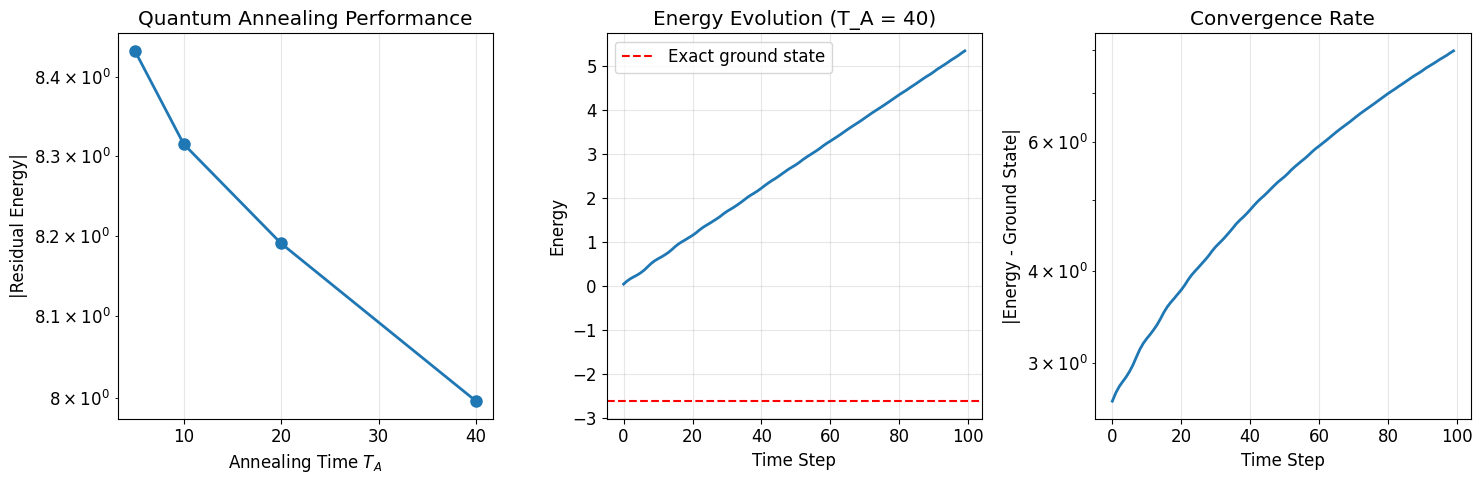


DEMO COMPLETE!
Best residual energy: 7.995994
Optimal annealing time: 40


In [7]:
# Quick demonstration with paper parameters
def quick_demo():
    """Run a quick demonstration with parameters from the paper."""
    print("\n" + "="*60)
    print("QUICK DEMO - Paper Parameters")
    print("="*60)
    
    # Parameters from the paper
    L = 4
    t_h = 1.0
    U = 4.0  # U/t_h = 4 as in the paper
    
    # Half-filled case: 2N_down = N = L
    N = L
    N_down = L // 2
    N_up = L - N_down
    
    print(f"System parameters: L={L}, U/t_h={U/t_h:.1f}")
    print(f"Particle numbers: N_up={N_up}, N_down={N_down}")
    
    # Create simulator
    simulator = HubbardQuantumAnnealing(L, t_h, U)
    
    # Get exact ground state energy
    print("\nCalculating exact ground state energy...")
    exact_energy = simulator.exact_ground_state_energy(N_up, N_down)
    
    if exact_energy is not None:
        print(f"Exact ground state energy: {exact_energy:.6f}")
        
        # Test different annealing times
        T_A_values = [5, 10, 20, 40]
        residual_energies = []
        
        print(f"\nTesting different annealing times...")
        
        for T_A in T_A_values:
            print(f"\n--- T_A = {T_A} ---")
            start_time = time.time()
            
            final_state, energies = simulator.quantum_annealing(
                N_up, N_down, T_A, n_steps=50
            )
            
            residual = simulator.calculate_residual_energy(final_state, exact_energy)
            residual_energies.append(residual)
            
            elapsed = time.time() - start_time
            print(f"Final energy: {energies[-1]:.6f}")
            print(f"Residual energy: {residual:.6f}")
            print(f"Computation time: {elapsed:.2f} seconds")
        
        # Plot results
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.semilogy(T_A_values, np.abs(residual_energies), 'o-', linewidth=2, markersize=8)
        plt.xlabel('Annealing Time $T_A$')
        plt.ylabel('|Residual Energy|')
        plt.title('Quantum Annealing Performance')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 3, 2)
        # Plot energy evolution for the best case
        best_T_A = T_A_values[np.argmin(np.abs(residual_energies))]
        final_state, energies = simulator.quantum_annealing(N_up, N_down, best_T_A, n_steps=100)
        
        plt.plot(energies, linewidth=2)
        plt.axhline(y=exact_energy, color='r', linestyle='--', label='Exact ground state')
        plt.xlabel('Time Step')
        plt.ylabel('Energy')
        plt.title(f'Energy Evolution (T_A = {best_T_A})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 3, 3)
        # Plot convergence rate
        convergence = [abs(e - exact_energy) for e in energies]
        plt.semilogy(convergence, linewidth=2)
        plt.xlabel('Time Step')
        plt.ylabel('|Energy - Ground State|')
        plt.title('Convergence Rate')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n" + "="*60)
        print("DEMO COMPLETE!")
        print(f"Best residual energy: {min(np.abs(residual_energies)):.6f}")
        print(f"Optimal annealing time: {T_A_values[np.argmin(np.abs(residual_energies))]}")
        print("="*60)
    else:
        print("Cannot calculate exact energy for this system size")

# Run the demo
quick_demo()

## 7. Analysis Tools

In [8]:
def analyze_state_properties(simulator, state, N_up, N_down):
    """Analyze properties of a quantum state."""
    
    # Calculate particle number operators
    n_up_total = np.zeros((2**simulator.n_qubits, 2**simulator.n_qubits), dtype=complex)
    n_down_total = np.zeros((2**simulator.n_qubits, 2**simulator.n_qubits), dtype=complex)
    
    for i in range(simulator.L):
        n_up = (simulator.I_ops[i] - simulator.Z_ops[i]) / 2
        n_down = (simulator.I_ops[i + simulator.L] - simulator.Z_ops[i + simulator.L]) / 2
        n_up_total += n_up
        n_down_total += n_down
    
    # Calculate expectation values
    n_up_exp = np.real(np.conj(state) @ n_up_total @ state)
    n_down_exp = np.real(np.conj(state) @ n_down_total @ state)
    
    print(f"Particle number expectations:")
    print(f"  <N_up> = {n_up_exp:.6f} (expected: {N_up})")
    print(f"  <N_down> = {n_down_exp:.6f} (expected: {N_down})")
    print(f"  <N_total> = {n_up_exp + n_down_exp:.6f}")
    
    # Calculate state fidelity with computational basis
    prob_distribution = np.abs(state)**2
    max_prob_idx = np.argmax(prob_distribution)
    
    print(f"\nState analysis:")
    print(f"  Max probability amplitude: {prob_distribution[max_prob_idx]:.6f}")
    print(f"  Number of significant components: {np.sum(prob_distribution > 1e-6)}")
    print(f"  State norm: {np.linalg.norm(state):.6f}")
    
    return {
        'n_up_exp': n_up_exp,
        'n_down_exp': n_down_exp,
        'max_prob': prob_distribution[max_prob_idx],
        'n_components': np.sum(prob_distribution > 1e-6)
    }

def plot_hamiltonian_spectrum(simulator, s_values):
    """Plot the energy spectrum of the Hamiltonian at different s values."""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, s in enumerate(s_values):
        H = simulator.hamiltonian(s)
        
        # Get lowest few eigenvalues
        if 2**simulator.n_qubits <= 2**10:
            eigenvalues = eigsh(csr_matrix(H), k=8, which='SA', return_eigenvectors=False)
            
            axes[idx].plot(range(len(eigenvalues)), eigenvalues, 'o-', linewidth=2, markersize=6)
            axes[idx].set_xlabel('Eigenstate Index')
            axes[idx].set_ylabel('Energy')
            axes[idx].set_title(f'Energy Spectrum at s = {s:.2f}')
            axes[idx].grid(True, alpha=0.3)
        else:
            axes[idx].text(0.5, 0.5, 'System too large\nfor spectrum analysis', 
                          ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].set_title(f'Energy Spectrum at s = {s:.2f}')
    
    plt.tight_layout()
    plt.show()

print("Analysis tools loaded successfully!")
print("\nAvailable functions:")
print("- analyze_state_properties(simulator, state, N_up, N_down)")
print("- plot_hamiltonian_spectrum(simulator, s_values)")

Analysis tools loaded successfully!

Available functions:
- analyze_state_properties(simulator, state, N_up, N_down)
- plot_hamiltonian_spectrum(simulator, s_values)


## 8. Usage Instructions

### How to use this notebook:

1. **Run the Quick Demo**: Cell 6 provides a ready-to-run demonstration with paper parameters

2. **Interactive Single Simulation**: 
   - Adjust parameters in Cell 3 using the sliders
   - Click "Run Simulation" in Cell 4 to see results

3. **Parameter Sweep Analysis**:
   - Set your desired parameters in Cell 3
   - Click "Run Parameter Sweep" in Cell 5 to test multiple annealing times

4. **Custom Analysis**: Use the analysis tools in Cell 7 for deeper insights

### Parameter Guide:
- **L**: Number of lattice sites (keep small: 2-6 for reasonable computation time)
- **U**: On-site interaction strength (try 0.5 to 8.0)
- **t_h**: Hopping parameter (typically 1.0 as reference)
- **T_A**: Annealing time (longer = better results but more computation)
- **Filling**: Particle filling configuration

### Key Physics:
- The simulation implements quantum annealing for the 1D Hubbard model
- Residual energy measures how close the final state is to the true ground state
- Longer annealing times generally give better results (lower residual energy)
- The system size limits are due to exponential scaling of the Hilbert space